<a href="https://colab.research.google.com/github/MohamedElashri/IsingModel/blob/main/Ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Ising Model
 2d Ising model Monte-Carlo Simulation

 Author: Mohamed Elashri 
 
 Email: elashrmr@mail.uc.edu

  ## Algorithm 
 1. Prepare some initial configrations of N spins. 
 2. Flip spin of a lattice site chosen randomly 
 3. Calculate the change in energy due to that 
 4. If this change is negative, accept such move. If change is positive,    accept it with probability exp^{-dE/kT}
 5. repeat 2-4. 
 6. calculate Other parameters and plot them 


I spent many nights working on this work, most of time I needed to opptimize my code, 
I even tried to move to matlab (last time I used it was like 5 years ago). 
But I learned a nice thing from my desire to optimize code speed. it is the usage of Numba’s JIT compiler. read more about jit compiler here. http://melashri.net/url/b.
I also instead of using multiple nested loops I dragged all these into just one. Interior loops in Python have always been slow due to the absence of type information. Python’s duck typing system really comes to bite when this absence of typing creates unnecessary code and indirection, leading to relatively slow inner loops. 



Imagine running 50x50 lattice simulation in my older codes for hours (one to ok 6 hours) vs 15 minutes for the currect script. (On my Mac m1 Machine).


Hint: It is much easier to run the work here on colab or take the python script to other platforms than Mac m1 as you will struggle with installing numba issues there (llvmlite required to build the package is not officially supported yet and the workaround is very technical and time consuming but the performance there is impressive). 

To install it on Mac m1 we do the following 



```
python3 -m pip install  conda 
```

```
python3 -m pip install  cytoolz
```

```
python3 -m conda config --add channels conda-forge
```

```
python3 -m  conda install -c numba numba
```

Hint: I'm assuming that we are using Python3 version from homebrew not the one comes with OS which we shouldn't work with or try to modify except for Mac OS stuff. This can be done by adding the path to `.bashrc` or `.zshrc` by adding `export PATH="/usr/local/opt/python/libexec/bin:$PATH"` line to the either files.

In [ ]:
# To know about colab specs and compare them with your machine for test comparisons 
!cat /proc/cpuinfo # For CPU
!cat /proc/meminfo # For memory

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 1999.999
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	:

In [ ]:
import matplotlib.pyplot as plt # The famous plotting library
from numba import jit # wonderful optimization compiler. 
import numpy as np  # we can't work in python without that in physics (maybe we can if we are not lazy enough)
import random # we are doing MC simulation after all!!
import time # for time estimation 
# from tqdm import tqdm # fancy progress bars for loops , use this line if working with .py script
from tqdm.notebook import tqdm # use this if working with jupyter notebook to avoid printing a new line for each iteration

In [ ]:
# Define parameters 

B = 0; # Magnetic field strength
L = 50; # Lattice size (width)
s = np.random.choice([1,-1],size=(L,L)) # Begin with random spin sites with values (+1 or -1) for up or down spins. 
n= 1000 * L**2 # number of MC sweeps 
Temperature = np.arange(1.6,3.25,0.01) # Initlaize temperature range (the range includes critical temperature) > takes form np.arange(start,stop,step)
  


'''
Energy of the lattice calculations. 
The energy here is simply the sum of interactions between spins divided by the total number of spins
'''
@jit(nopython=True) # wonderful jit optimization compiler in its high performance mode
def calcE(s):
    E = 0
    for i in range(L):
        for j in range(L):
            E += -dE(s,i,j)/2
    return E/L**2

'''
Calculate the Magnetization of a given configuration
Magnetization is the sum of all spins divided by the total number of spins

'''
@jit(nopython=True) # wonderful jit optimization compiler in its high performance mode
def calcM(s):
    m = np.abs(s.sum())
    return m/L**2

# Calculate interaction energy between spins. Assume periodic boundaries
# Interaction energy will be the difference in energy due to flipping spin i,j 
# (Example: 2*spin_value*neighboring_spins)
@jit(nopython=True) # wonderful jit optimization compiler in its high performance mode
def dE(s,i,j): # change in energy function
    #top
    if i == 0:
        t = s[L-1,j]  # periodic boundary (top)
    else:
        t = s[i-1,j]
    #bottom
    if i == L-1:
        b = s[0,j]  # periodic boundary (bottom)
    else:
        b = s[i+1,j]
    #left
    if j == 0:
        l = s[i,L-1]  # periodic boundary (left)
    else:
        l = s[i,j-1]
    #right
    if j == L-1:
        r = s[i,0]  # periodic boundary  (right)
    else:
        r = s[i,j+1]
    return 2*s[i,j]*(t+b+r+l)  # difference in energy is i,j is flipped

# Monte-carlo sweep implementation
@jit(nopython=True) # wonderful jit optimization compiler in its high performance mode
def mc(s,Temp,n):   
    for m in range(n):
        i = random.randrange(L)  # choose random row
        j = random.randrange(L)  # choose random column
        ediff = dE(s,i,j)
        if ediff <= 0: # if the change in energy is negative
            s[i,j] = -s[i,j]  # accept move and flip spin
        elif random.random() < np.exp(-ediff/Temp): # if not accept it with probability exp^{-dU/kT}
            s[i,j] = -s[i,j]
    return s

# Compute physical quantities
@jit(nopython=True)  # wonderful jit optimization compiler in its high performance mode
def physics(s,T,n):
    En = 0
    En_sq = 0
    Mg = 0
    Mg_sq = 0
    for p in range(n):
        s = mc(s,T,1)
        E = calcE(s)
        M = calcM(s)
        En += E
        Mg += M
        En_sq += E*E
        Mg_sq += M*M
    En_avg = En/n
    mag = Mg/n
    CV = (En_sq/n-(En/n)**2)/(T**2)
    return En_avg, mag, CV

In [ ]:
# Inititalize magnetization, average energy and heat capacity
mag = np.zeros(len(Temperature))
En_avg = np.zeros(len(Temperature))
CV = np.zeros(len(Temperature))

start = time.time()

# Simulate at particular temperatures (T) and compute physical quantities (Energy, heat capacity and magnetization)
for ind, T in enumerate(tqdm(Temperature)):
    # Sweeps spins
    s = mc(s,T,n)
    # Compute physical quanitites with 1000 sweeps per spin at temperature T
    En_avg[ind], mag[ind], CV[ind] = physics(s,T,n)
end = time.time()
time = (end - start)/60
print('It took ' + str(time) + ' minutes to execute the code')


It took 41.593717606862384 minutes to execute the code


It takes about 40 minutes for 50x50 lattice on my free colab instance. Colab provide pro plan which gives you double of specs but it is overkill of our purposes. maybe if we try a CUDA implementation for higher dimensions this could be helpful. 

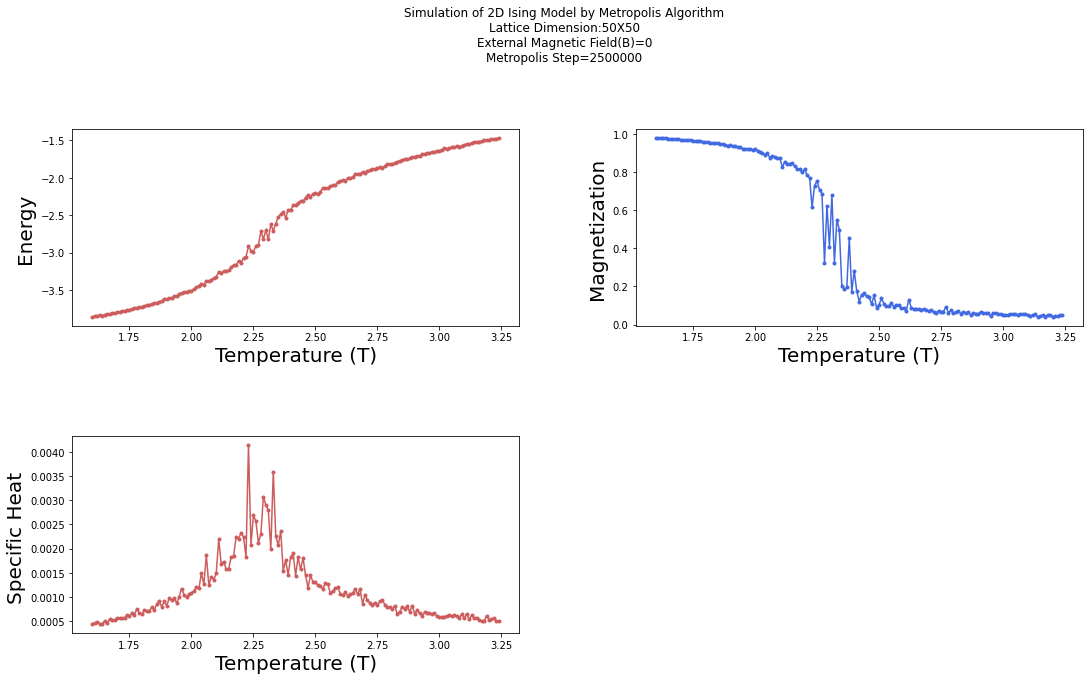

In [ ]:
#----------------------------------------------------------------------
#  Plotting area
#----------------------------------------------------------------------


f = plt.figure(figsize=(18, 10)); # plot the calculated values  
sp =  f.add_subplot(2, 2, 1 );
plt.plot(Temperature, En_avg, marker='.', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(Temperature, abs(mag), marker='.', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.plot(Temperature, CV, marker='.', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

plt.subplots_adjust(0.12, 0.11, 0.90, 0.81, 0.26, 0.56)
plt.suptitle("Simulation of 2D Ising Model by Metropolis Algorithm\n" + "Lattice Dimension:" + str(L) + "X" + str(
    L) + "\n" + "External Magnetic Field(B)=" + str(B) + "\n" + "Metropolis Step=" + str(n))



plt.show() # function to show the plots


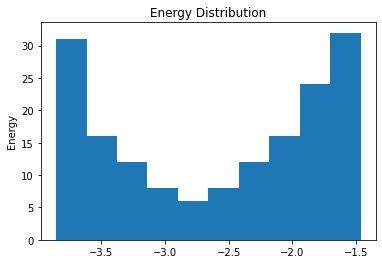

In [10]:
plt.hist(En_avg, bins=10)
plt.gca().set(title='Energy Distribution', ylabel='Energy');